## Preliminary exploratory data analysis

In [3]:
#Load all the package that we need
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(rsample)   
library(caret)     
library(pROC)  
library(dplyr)
library(ggplot2)
install.packages("caret")
library(caret)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

### Reading data
We used `"read_csv"` function to import the Cleveland Heart Disease dataset. The dataset contains 303 patient records and 14 clinical attributes. The dataset was initially loaded without column names, so we manually assigned names to each clinical attribute to ensure accurate data processing and analysis.

### Data cleaning and tidying
Upon initial inspection, we found that missing values were denoted by "? ", so we converted the missing values to "NA" to ensure that R could be processed and analyzed correctly. Certain variables (e.g., gender, fbs, restecg, exang, thal, ca, and slope) were expected to be categorical in nature, so we converted them to factor variables. Finally, we converted the response variable num into a binary factor called diag, where 0 corresponds to "FALSE" for no heart disease and 1 through 4 correspond to "TRUE" for heart disease. The purpose of converting the "num" column to the binary "diag" column was to simplify the dataset, bring clarity to the standardized treatment protocols, and ensure consistent care for patients across a variety of providers.

In [4]:
cleveland_data<-read_csv( "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                col_names=c("age",
                     "sex",
                     "cp",
                     "trestbps",
                     "chol",
                     "fbs",
                     "restecg",
                     "thalach",
                     "exang",
                     "oldpeak",
                     "slope",
                     "ca",
                     "thal",
                     "num")) 

set.seed(123)
#Now we can cleaning and wrangling data
cleveland_data[cleveland_data == "?"] <- NA

# Convert necessary columns to appropriate types
cleveland_tidy <- cleveland_data|>
  mutate(across(c("sex", "fbs", "restecg", "exang", "thal", "ca", "slope"), as.factor)) %>%
  mutate(
    num = as.numeric(num), 
    diag = factor(ifelse(is.na(num), NA, num > 0))) 

head(cleveland_tidy) 



Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,FALSE


#### Figure 1

### Splitting data into training and testing sets
In preparing the Cleveland dataset for the development of the predictive model, we divided the dataset into a training subset and a testing subset. This is a critical step as it ensures that the model is trained on a comprehensive and representative portion of the data, while also reserving a separate portion for model evaluation to validate its predictive accuracy. The data set was partitioned using the `"initial_split"` function. This function assigns about 75% of the data to the training set and the remaining 25% to the test set.

In [6]:
#Splitting dataframe into training and testing datasets
cleveland_split<-initial_split(cleveland_tidy,prop=3/4,strata=num)
cleveland_training<-training(cleveland_split)
cleveland_testing<-testing(cleveland_split)


head(cleveland_training)

nrow(cleveland_training)
nrow(cleveland_testing)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,FALSE
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0,FALSE
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,0,FALSE
56,0,2,140,294,0,2,153,0,1.3,2,0.0,3.0,0,FALSE
44,1,2,120,263,0,0,173,0,0.0,1,0.0,7.0,0,FALSE


[1] 225

[1] 78

#### Figure 2

### Summarizing the data
We can use the `"group_by"` and `"summarize"` functions to determine whether "cp" and " trestbps" are related to the diagnosis of heart disease ("diag"). So we can use `“mean”` to find their average value to confirm it. By comparing the data we can see that higher avg_trestbps increases the probability of having a heart attack while higher avg_cp may affect the diagnosis rate (note: cp stands for different types of chest painValue 1: typical angina -- Value 2: atypical angina -- Value 3: non-anginal pain -- Value 4: asymptomatic).

In [7]:
cleveland_summary <- cleveland_training|>
  group_by(diag)|>
  summarize(
    avg_cp = mean(cp, na.rm=TRUE),
    avg_trestbps = mean(trestbps, na.rm = TRUE),
    count = n())
cleveland_summary

diag,avg_cp,avg_trestbps,count
<fct>,<dbl>,<dbl>,<int>
FALSE,2.827869,128.9836,122
TRUE,3.553398,135.4757,103


#### Figure 3

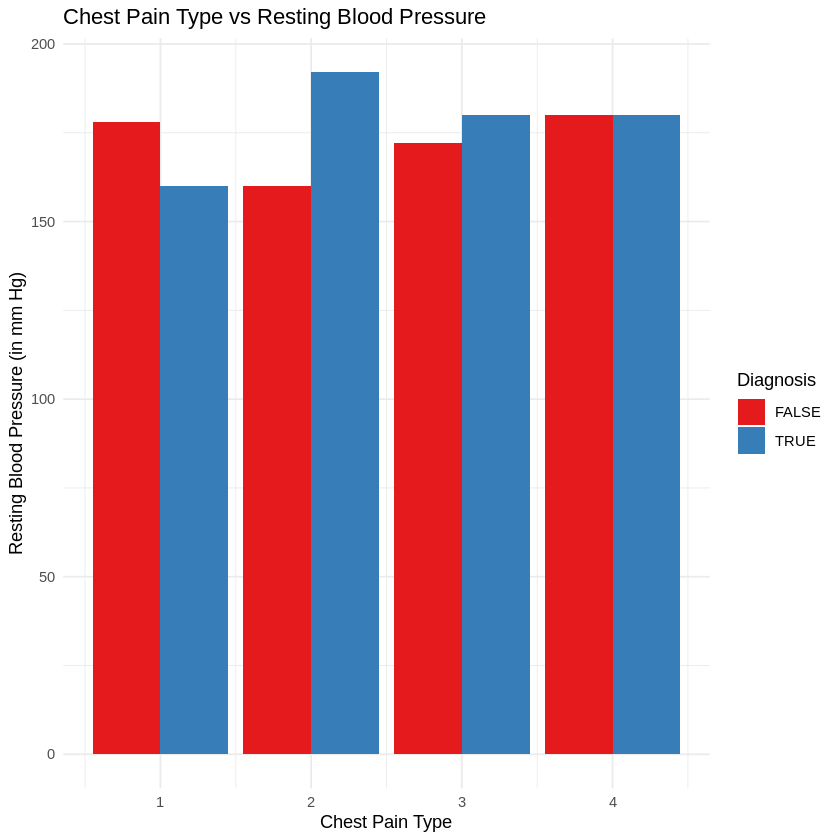

In [8]:
#Now, we can plot the graph 
cleveland_plot <-ggplot(cleveland_training, aes(x =cp , y =trestbps, fill = diag)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(title = "Chest Pain Type vs Resting Blood Pressure ",
       x = "Chest Pain Type",
       y = "Resting Blood Pressure (in mm Hg)",fill="Diagnosis") +
  scale_fill_brewer(palette = "Set1") +
  theme_minimal()
cleveland_plot 

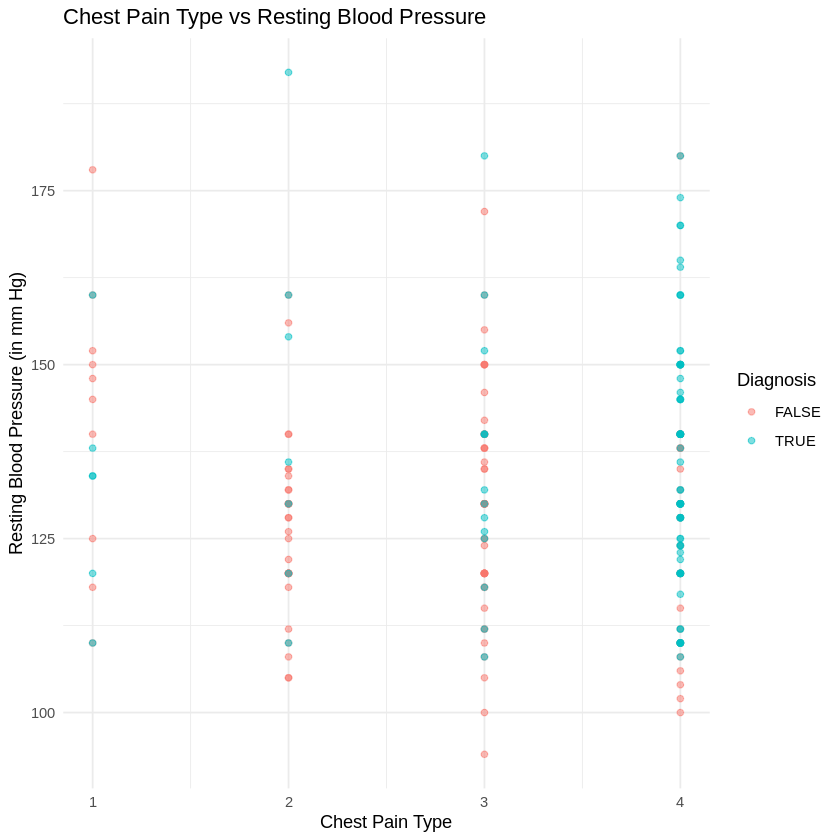

In [13]:
cleveland_plot<-cleveland_training|>
    ggplot(aes(x=cp,y=trestbps,color=diag))+
    geom_point(alpha=0.5)+
    labs(title = "Chest Pain Type vs Resting Blood Pressure ",
       x = "Chest Pain Type",
       y = "Resting Blood Pressure (in mm Hg)", color="Diagnosis")+
    scale_fill_brewer(palette = "Set2") +
    theme_minimal()
cleveland_plot

#### Figure 4

### Model Development and Optimization Using k-Nearest Neighbors
We initialized our modeling process by standardizing the predictors (cp and trestbps). This was achieved through scaling (to unit variance) and centering (to zero mean) using the recipe function. Such standardization is crucial in distance-based algorithms like k-NN to prevent attributes with naturally larger ranges from dominating the distance calculations.he k-NN model was specified with a rectangular weight function, and the number of neighbors was set to be tuned dynamically.  We employed the kknn engine, well-suited for this kind of model, and configured the model for classification To validate our model, we performed 10-fold cross-validation on the training dataset, stratifying by the diag outcome to ensure balanced sampling within each fold. This method helps in evaluating the model's performance and robustness effectively. A grid of potential values for k (ranging from 1 to 100) was prepared. We tuned the model across these values to find the optimal number of neighbors that maximizes accuracy, which is essential for achieving the best balance between bias and variance.

### Evaluation and Results
After tuning, we collected accuracy metrics for each model configuration, focusing on the accuracy as the primary performance measure.  The accuracy metrics were filtered and sorted to identify the top configurations. This helped in selecting the best k value based on empirical evidence.
### Top Performing ModelsThe analysis of the highest results shows that the configurations with the highest accuracy metrics provide the most efficient settings for our k-NN model. We extracted the first 5 configurations for detailed comparison showing that the 11th neighbor has the highest average accuracy of about 77.24%, indicating it as the most suitable choice for this dataset and model. 
..


In [72]:
set.seed(123)

#Performing Standardization
cleveland_recipe<-recipe(diag~ cp+trestbps, data=cleveland_training)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

# K-nearest neighbour model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
            set_engine("kknn")|>
            set_mode("classification")

# Perform 10 fold-cross valdiation
cleveland_vfold <- vfold_cv(cleveland_training, v = 10, strata = diag)

gridvals <- tibble(neighbors = c(1:100))

# Create workflow and tune
knn_results <- workflow()|>
      add_recipe(cleveland_recipe)|>
      add_model(knn_tune)|>
      tune_grid(resamples = cleveland_vfold, grid = gridvals)|>

# Collect metrics and filter for accuracy
      collect_metrics()|>
      filter(.metric == "accuracy")|>
      select(neighbors, mean)|>
      arrange(desc(mean))

# Check top results for the best number of neighbors
top_results <- knn_results|>
      arrange(desc(mean))|>
      slice_head(n = 5)

head(top_results)

neighbors,mean
<int>,<dbl>
11,0.7724144
12,0.7682477
85,0.7555665
86,0.7510211
87,0.7510211


#### Figure 5

### Final Model Specification and Training
Finally, we have a value for K (k=11), we can now create `"neighbors = 11"`. Then we can fit our model to `"cleveland_training"`.


In [89]:
set.seed(123)

cleveland_final_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 11)|>
    set_engine("kknn")|>
    set_mode("classification")

cleveland_fit <- workflow()|>
    add_recipe(cleveland_recipe)|>
    add_model(final_spec)|>
    fit(data = cleveland_training)

cleveland_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2311111
Best kernel: rectangular
Best k: 11

#### Figure 6

### Testing our model
In the final stage, we will utilize a test set to test how well our model performs. To do this, We used the `"predict"` function to predict the diagnosis of heart disease (diag ) on the test set (cleveland_testing ). These predictions were combined with the actual diagnoses in the test set for a comprehensive evaluation. We then need to look at its accuracy using metrics and its confusion matrix using conf_mat. 

We computed the overall accuracy of the model, which was found to be approximately 76.92%. It reflects the proportion of total correct predictions made.
sea

This information is critical to understanding the diagnostic strengths and weaknesses of the model. Specifically, the relatively high number of false negatives may be of clinical concern because it represents underdiagnosis of heart disease. Conversely, the low false-negative rate suggests that the model is conservative, favoring underdiagnosis over overdiagnosis. These results demonstrate the potential of the k-NN model as a diagnostic tool, while also emphasizing the importance of continuous improvement and validation.
se.


In [94]:
set.seed(123)

#Predict the test sed
cleveland_predictions<-predict(fit, cleveland_testing)|>
               bind_cols(cleveland_testing)

metrics<- cleveland_predictions|>
    metrics(truth = diag, estimate = .pred_class)|>
    filter(.metric == "accuracy") 

metrics

#confusion matrix, identifies the areas the model is weak at classifying
conf_mat<-cleveland_predictions|>
    conf_mat(truth = diag, estimate = .pred_class)
conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7692308


          Truth
Prediction FALSE TRUE
     FALSE    36   12
     TRUE      6   24

#### Figure 7